# Analysing heart rate during 7 days activities
- Object: Mouse 4
- Duration: 2023-07-01 22:16:57 to 2023-07-07 23:10:45
- GA admnistration: 2023-07-05 16:00 to 21:00

In [6]:
import numpy as np
import pyhrv.tools as tools
import mat73
from datetime import datetime, timedelta
import logging as log

import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

In [7]:
from pyhrv import hrv
import pyhrv.time_domain as td 

In [70]:
class AdInstrumentData:
    
    def __init__(self, mat_files):
        # matfiles: can load several mat files
        
        data_dict = mat73.loadmat(mat_files[0])
        # extract start time
        data_starts = data_dict['record_meta']['data_start']
        self.__start_time = self.__days2datetime(data_starts[0]) if isinstance(data_starts, list) else self.__days2datetime(data_starts)
        
        # extract data frequency
        tick_dts = data_dict['record_meta']['tick_dt']
        self.__fs = 1/tick_dts[0] if isinstance(tick_dts, list) else 1/tick_dts

        from operator import itemgetter
        self.__template = 'data__chan_'
        all_ticks = {}
        
        def extract_ticks(data, all_ticks):
            # combine all ticks
            
            tmp_keys = []
            for key in data.keys():
                if self.__template in key:
                    tmp_keys += [[int(k) for k in key.split('_') if k.isnumeric()] + [key]]
            tmp_keys = sorted(tmp_keys, key=itemgetter(0, 1))

            for l_key in tmp_keys:
                key = self.__template + str(l_key[0])
                if type(data[l_key[-1]]) == np.ndarray:
                    all_ticks[key] = np.concatenate((all_ticks[key], data[l_key[-1]])) if key in all_ticks else data[l_key[-1]]

        extract_ticks(data_dict, all_ticks)
        for file in mat_files[1:]:
            extract_ticks(mat73.loadmat(file), all_ticks)
        self.__all_ticks = all_ticks
        self.__tick_len = len(list(all_ticks.values())[0])
        
        self.__stop_time = self.__start_time + timedelta(seconds=len(self.all_ticks[self.__template+'1'])/self.__fs)
        
        self.__date_format = "%Y-%m-%d %H:%M:%S.%f"
        
        log.info(f'Labchart data from {str(self.__start_time)} to {str(self.__stop_time)}')
        
    def __days2datetime(self, days):
        # days, ex: array(739071.96513903)
        reference_date = datetime(1, 1, 1)
        return reference_date + timedelta(days=float(days)-367)
    
    def __tick_pos2datetime(self, tick_pos:int):
        """
        args:
            tick_pos: position of tick
        return:
            date_time in datetime format
        """
        seconds = tick_pos / self.__fs
        return self.__start_time + timedelta(seconds=seconds)
    
    def __datetime2tick_pos(self, date_time):
        """
        args:
            date_time: date and time in sting or datetime data type
        return:
            position of ticks
        """
        if isinstance(date_time, str):
            date_time = datetime.strptime(date_time, self.__date_format)
        if isinstance(date_time, datetime):
            return round((date_time - self.__start_time).total_seconds() * self.__fs)
        return None
    
    @property
    def start_time(self):
        return self.__start_time
    
    @property
    def finish_time(self):
        return self.__stop_time
    
    @property
    def fs(self):
        return self.__fs
    
    @property
    def all_ticks(self):
        return self.__all_ticks
    
    @property
    def tick_len(self):
        return self.__tick_len
    
    @property
    def channels(self):
        return [c[len(self.__template):] for c in self.__all_ticks.keys()]
        
    def __get_ecg_range(self, channel, from_time=None, to_time=None, duration=3600):
        """
        from_time : time to start
        to_time: time to finish
        duration : duration in seconds, default = 1 hours = 60 * 60 seconds
        channel : start from 1
        return: validity(%), ticks, from_time, to_time
        """
        if from_time is None:
            from_time = self.__start_time
        start_tick = self.__datetime2tick_pos(from_time)
        if to_time is None and duration:
            finish_tick = start_tick + duration
            to_time = self.__tick_pos2datetime(finish_tick)
        elif to_time is not None:
            finish_tick = self.__datetime2tick_pos(to_time)
        if finish_tick > self.__tick_len:
            finish_tick = self.__tick_len
            to_time = self.__tick_pos2datetime(finish_tick)
        
        
        if start_tick >= self.__tick_len or start_tick >= finish_tick:
            return None
        
        tick_channel = self.__template + str(channel)
        validity_channel = self.__template + str(channel + 1 if (channel + 1) % 3 == 0 else channel + 2)
        
        ticks = self.__all_ticks[tick_channel][start_tick:finish_tick]
        validity = self.__all_ticks[validity_channel][start_tick:finish_tick]            
        
        
        # calculate validity level
        val_level = np.mean(validity)
        # remove ticks with invalid recording
        condition = validity < 0.5
        filtered_ticks = ticks[~condition]

        return val_level, filtered_ticks, from_time, to_time
        
    def get_data(self, channel, from_time=None, to_time=None, duration=3600):
        """
        from_time : time to start
        to_time: time to finish
        duration : duration in seconds, default = 1 hours = 60 * 60 seconds
        channel : start from 1
        return: validity(%), ticks, from_time, to_time
        """
        val_level, signal, from_time, to_time = self.__get_ecg_range(channel, from_time, to_time, duration)
        
        # GET PEAKS
        # rqrs config file for mouse
        # using PhysioZoo setup
        hr = 608
        qs = 0.00718
        qt = 0.03
        QRSa = 1090
        QRSamin = 370
        rr_min = 0.05
        rr_max = 0.24
        window_size_sec = 0.005744 # 0.8*QS

        # adjusting peaks location
        peaks_window = 17
        th = 0.5
        # Use the maximum possible bpm as the search radius
        # Ostergaard G, Hansen HN, Ottesen JL. Physiological, Hematological, and Clinical Chemistry Parameters, Including Conversion Factors. In: Hau J, Schapiro SJ, editors. Handbook of laboratory animal science, Volume I: Essential Principles and Practices. 3rd ed. Vol. 1. Boca Raton, FL: CRC Press; 2010. pp. 667–707.
        min_bpm = 310
        max_bpm = 840
        search_radius = int(self.__fs * 60 / max_bpm)

        # Use the GQRS algorithm to detect QRS locations in the first channel
        qrs_inds = processing.qrs.gqrs_detect(sig=signal, 
                                              fs=self.__fs, 
                                              RRmin=rr_min, 
                                              RRmax=rr_max,
                                              hr=hr, 
        #                                       QS=qs, 
                                              QT=qt, 
                                              QRSa=QRSa, 
        #                                       QRSamin=QRSamin
                                             )
        
        # Correct the peaks shifting them to local maxima
        peaks = processing.peaks.correct_peaks(
            signal,
            peak_inds=qrs_inds,
            search_radius=search_radius, 
            smooth_window_size=peaks_window
        )
        
#         def filter_signal_peaks(nni, condition, signal, peaks):
#             nni_range = np.array(list(zip(peaks[:-1], peaks[1:])))
#             delete = nni_range[~condition]
#             delete_mask = np.ones(len(signal), dtype=bool)
#             for start, end in delete:
#                 delete_mask[start:end] = False
#             signal = signal[delete_mask]
#             # delete related peak
#             peaks = np.insert(np.cumsum(nni)+peaks[0], 0, peaks[0])
#             return signal, peaks
    
        # GET NNI, THEN FILTER NNI and PEAKS
        nni = np.diff(peaks)
        condition = (nni >= rr_min*self.__fs) & (nni <= rr_max*self.__fs)
        nni = nni[condition]
#         # delete related signal and peaks
#         signal, peaks = filter_signal_peaks(nni, condition, signal, peaks)
        
        # filter nni within mean +- std2x
        nni_mean = np.mean(nni)
        std2x = 2 * np.std(nni)
        condition = (nni >= nni_mean-std2x) & (nni <= nni_mean+std2x)
        nni = nni[condition]
#         # delete related signal and peaks
#         signal, peaks = filter_signal_peaks(nni, condition, signal, peaks)
        
        # get activity in lower channel
        tick_channel = self.__template + str(channel-1)
        start_tick = self.__datetime2tick_pos(from_time)
        end_tick = self.__datetime2tick_pos(to_time)
        activity = self.__all_ticks[tick_channel][start_tick:end_tick]
#         if start_tick + number_of_tick <= self.__tick_len:
#             activity = self.__all_ticks[tick_channel][start_tick:start_tick + number_of_tick]
#         else:
#             activity = self.__all_ticks[tick_channel][start_tick:]
        
#         return {"val_level": val_level, "signal": signal, "nni": nni, "peaks": peaks, "activity": activity}

        return {"val_level": val_level, "nni": nni, "from_time": from_time, "to_time":to_time, "activity": activity}
    
    

In [350]:
original_files = [
    'Mouse03 to 06_20230701 pm.mat',
    'Mouse03 to 06_20230702 am.mat',
    'Mouse03 to 06_20230702 pm.mat',
    'Mouse03 to 06_20230704 am.mat',
    'Mouse03 to 06_20230704 pm.mat',
    'Mouse03 to 06_20230705 am.mat',
    'Mouse03 to 06_20230705 pm.mat',
    'Mouse03 to 06_20230706 am.mat',
    'Mouse03 to 06_20230706 pm.mat',
    'Mouse03 to 06_20230707 am.mat',
    'Mouse03 to 06_20230707 pm.mat',
    'Mouse03 to 06_20230708 am.mat'
    
]

In [376]:
log.basicConfig(level=log.INFO)

start_time = None
finish_time = None
duration = 3600 #1 hour
channel = 5
ecg = None

ecg_collections = []

for file in original_files:
    raw_data = AdInstrumentData([f'data/{file}'])
    print(raw_data.start_time, raw_data.finish_time)
    fetch_size = int(raw_data.fs * duration)
    loop_range = int(np.ceil(raw_data.tick_len / fetch_size))
    
    if start_time is None:
        start_time = raw_data.start_time
        finish_time = start_time + timedelta(seconds=duration)
    
    for i in tqdm(range(loop_range)):
        
        if ecg is None:
            start_time = start_time if start_time >= raw_data.start_time else raw_data.start_time
            ecg = raw_data.get_data(channel, from_time=start_time, to_time=finish_time)
        else:
            ecg_add = raw_data.get_data(channel, to_time=finish_time)
            sc = (ecg['to_time'] - ecg['from_time']).total_seconds()
            sc_add = (ecg_add['to_time'] - ecg_add['from_time']).total_seconds()
            ecg['val_level'] = (ecg['val_level'] * sc + ecg_add['val_level'] * sc_add) / (sc + sc_add)
            ecg['nni'] = np.concatenate([ecg['nni'], ecg_add['nni']])
            ecg['activity'] = np.concatenate([ecg['activity'], ecg_add['activity']])
            ecg['to_time'] = ecg_add['to_time']
        if finish_time <= raw_data.finish_time:
            ecg_collections += [ecg]
            start_time = finish_time
            finish_time = start_time + timedelta(seconds=duration)
            ecg = None

    
#     fetch_size = int(raw_data.fs * duration)
#     loop_range = int(raw_data.tick_len / fetch_size) + 1
    
#     for i in tqdm(range(loop_range)):
#         start_tick = int(i * fetch_size)
#         try:
#             ecg = raw_data.get_data(start_tick, 5, number_of_tick=fetch_size)
#             ecg_collections += [ecg]
#         except:
#             ecg_collections += [None]
#             log.error(f'{file} segmen {start_tick} to {start_tick+fetch_size} is unusable')
            

2023-07-01 22:16:57.413498 2023-07-02 10:16:57.413498


100%|██████████████████████████████████| 12/12 [02:56<00:00, 14.75s/it]


2023-07-02 10:17:07.660798 2023-07-02 22:17:07.660798


100%|██████████████████████████████████| 12/12 [02:43<00:00, 13.62s/it]


2023-07-02 22:17:14.762771 2023-07-03 10:17:14.762771


100%|██████████████████████████████████| 12/12 [02:50<00:00, 14.20s/it]


2023-07-03 10:17:20.962828 2023-07-04 23:07:03.862828


100%|██████████████████████████████████| 37/37 [08:49<00:00, 14.30s/it]


2023-07-04 23:09:48.011821 2023-07-05 11:09:48.011821


100%|██████████████████████████████████| 12/12 [02:58<00:00, 14.85s/it]


2023-07-05 11:09:58.590943 2023-07-05 23:09:58.590943


100%|██████████████████████████████████| 12/12 [02:49<00:00, 14.08s/it]


2023-07-05 23:10:06.994679 2023-07-06 11:10:06.994679


100%|██████████████████████████████████| 12/12 [03:05<00:00, 15.42s/it]


2023-07-06 11:10:16.335526 2023-07-06 23:10:16.335526


100%|██████████████████████████████████| 12/12 [03:06<00:00, 15.55s/it]


2023-07-06 23:10:25.778564 2023-07-07 11:10:25.778564


100%|██████████████████████████████████| 12/12 [02:57<00:00, 14.83s/it]


2023-07-07 11:10:34.131446 2023-07-07 23:10:34.131446


100%|██████████████████████████████████| 12/12 [02:54<00:00, 14.53s/it]


2023-07-07 23:10:45.667262 2023-07-08 11:10:45.667262


100%|██████████████████████████████████| 12/12 [02:58<00:00, 14.91s/it]


2023-07-08 11:10:53.354868 2023-07-08 23:10:53.354868


100%|██████████████████████████████████| 12/12 [02:33<00:00, 12.75s/it]


In [379]:
with open('ecg_collections.npy', 'wb') as f:
    np.save(f, ecg_collections)

In [380]:
len(ecg_collections)

168

In [381]:
calculated = {'hr_means':[], 'pnn6':[], 'sdnn':[], 'activity':[], 'val_level':[], 'from_time':[], 'to_time':[]}
for ecg in tqdm(ecg_collections):
    if ecg is not None:
        hr_parameter = td.hr_parameters(nni=ecg['nni'])
        calculated['hr_means'] += [hr_parameter[0]]
        calculated['pnn6'] += [td.nnXX(nni=ecg['nni'], threshold=6)[1]]
        calculated['sdnn'] += [td.sdnn(nni=ecg['nni'])[0]]
        calculated['activity'] += [np.mean(ecg['activity'])]
    elif hr_means[-1] is not None:
        calculated['hr_means'] += [hr_means[-1]]
        calculated['pnn6'] += [pnn6[-1]]
        calculated['sdnn'] += [sdnn[-1]]
        calculated['activity'] += [activity[-1]]
    calculated['val_level'] += [ecg['val_level']]
    calculated['from_time'] += [ecg['from_time']]
    calculated['to_time'] += [ecg['to_time']]
    


In [382]:
rate = 1 # to make it one hour
results = {'hr_means':[], 'pnn6':[], 'sdnn':[], 'activity':[], 'val_level':[]}
day_positions = []
day_labels = []
for i in range(int((len(calculated['hr_means'])/rate) + 1)):
    for key in calculated.keys():
        if key not in ['from_time', 'to_time']:
            start = i * rate
            end = start+rate if start+rate < len(calculated[key]) else len(calculated[key])
            results[key] += [np.mean(calculated[key][start:end])]

In [383]:
day_labels = [(i, label) for i, label in enumerate(calculated['from_time']) if i%24==0]


In [384]:
# Create a colormap to map data values to background colors
colormap = plt.get_cmap('viridis')

# Normalize data values to map them to colors in the colormap
norm = Normalize(vmin=min(calculated['val_level']), vmax=max(calculated['val_level']))

# # Create a heatmap using imshow with the background colors based on data values
alpha_value = 0.2
background_colors = [colormap(norm(value), alpha=alpha_value) for value in calculated['val_level']]


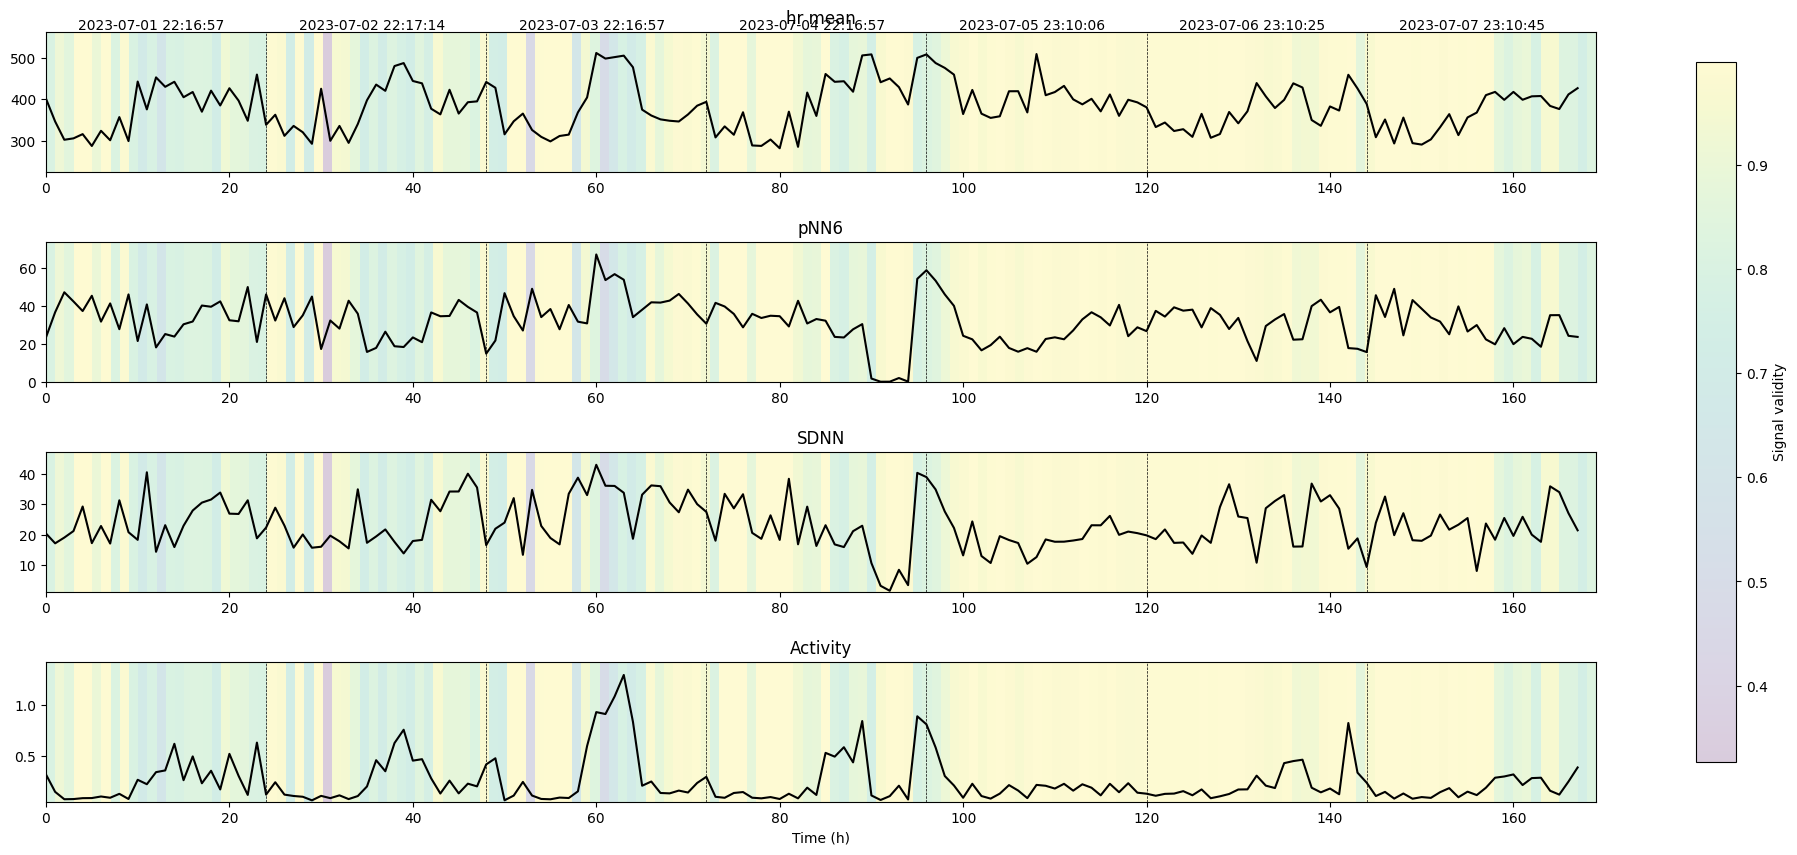

In [391]:
##### import matplotlib.pyplot as plt
from scipy import interpolate

x = np.array(range(len(results['hr_means'])))

# # multiply by 10
# xx = np.linspace(x.min(), x.max(), len(x) * 1000) 

# spl = interpolate.make_interp_spline(x, hr_means, k=5)  # type: BSpline
# hr_interpolated = spl(xx)

# # f_ecg = interpolate.interp1d(x, hr_means, kind='cubic', fill_value= 'extrapolate', )
# f_ecg = interpolate.make_interp_spline(x, hr_means)
# xx = np.arange(0, np.max(x))
# hr_interpolated = f_ecg(xx)

fig, ax = plt.subplots(4, 1, figsize=(20, 10))

multiply_high = 1.1
multiply_low = 0.8

# plt.subplot(411)
ax[0].set_title('hr mean')
ax[0].imshow([background_colors], aspect='auto', extent=[0, len(x), min(results['hr_means'])*multiply_low , max(results['hr_means'])*multiply_high])
ax[0].plot(x, results['hr_means'], color='k')
# # Add vertical lines to mark each day
for day_position, day_label in day_labels:
    ax[0].axvline(x=day_position, color='black', linestyle='--', linewidth=0.5)
    ax[0].text(day_position + 11.5, ax[0].get_ylim()[1]+15, str(day_label.strftime('%Y-%m-%d %H:%M:%S')), fontsize=10, ha='center', va='center')

# plt.subplot(412)
ax[1].set_title('pNN6')
ax[1].imshow([background_colors], aspect='auto', extent=[0, len(x), min(results['pnn6'])*multiply_low , max(results['pnn6'])*multiply_high])
ax[1].plot(x, results['pnn6'], color='k')
# # Add vertical lines to mark each day
for day_position, day_label in day_labels:
    ax[1].axvline(x=day_position, color='black', linestyle='--', linewidth=0.5)

# plt.subplot(413)
ax[2].set_title('SDNN')
ax[2].imshow([background_colors], aspect='auto', extent=[0, len(x), min(results['sdnn'])*multiply_low , max(results['sdnn'])*multiply_high])
ax[2].plot(x, results['sdnn'], color='k')
# # Add vertical lines to mark each day
for day_position, day_label in day_labels:
    ax[2].axvline(x=day_position, color='black', linestyle='--', linewidth=0.5)

# plt.subplot(414)
ax[3].set_title('Activity')
ax[3].imshow([background_colors], aspect='auto', extent=[0, len(x), min(results['activity'])*multiply_low , max(results['activity'])*multiply_high])
ax[3].plot(x, results['activity'], color='k')
# # Add vertical lines to mark each day
for day_position, day_label in day_labels:
    ax[3].axvline(x=day_position, color='black', linestyle='--', linewidth=0.5)

plt.xlabel('Time (h)')

plt.subplots_adjust(hspace=0.5)

# Create a colorbar legend for the colormap
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cb = plt.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=norm), cax=cax)
cb.set_label('Signal validity')
cb.solids.set(alpha=alpha_value)

# plt.ylabel('RR-interval (ms)')

plt.show()